<a href="https://colab.research.google.com/github/Eddav29/MachineLearning_Ganjil_2024/blob/main/Jobsheet_10_RNN(Recurrent_Neural_Network)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Jobsheet 10 Recurrent Neural Network**
## **Eddo Dava Alfarisi**
## **2241720232**

link
[Collab](https://colab.research.google.com/drive/1ZHhJqp2e9TCk_4CrAskmN0_WD8ZJ5de-?usp=sharing)


Link [Github](https://)

# **Praktikum 1**

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])


## **Setup input Pipeline**

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
#@title Mereturn data set ( text dan label)
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
#@title  acak data untuk Training dan Test dan membuat kumpulan pasangan (teks, label) ini:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'The films of UPA are surprisingly well rated on IMDb despite the fact that the animation quality is light-years behind that of Looney Toons, Disney and MGM at their prime. Sadly, due to rising costs in making pretty cartoons with high frame-rates and lovely backgrounds, the UPA style (which debuted about 1950) began to dominate in the late 50s and 60s. After all, the films were dirt cheap to make and they\'d received several Oscars to "prove" that the cartoons were now mainstream. So as a result, lousy animation was becoming the norm and this trend wasn\'t reversed until the 1980s.<br /><br />This UPA film is one of the early ones. The characters are very simply drawn (any simpler and they would have used stick figures) and the backgrounds were ugly--simple line drawings with colors added in a very slap-dash manner (often with a sponge and rarely completely filling the items).<br /><br />As for the story, it\'s a jive story with a strong jazz style attitude. Some will love t

In [ ]:
#@title Teks Encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

membuat encoding teks (text encoding) menggunakan layer TextVectorization dari TensorFlow Keras, yang bertujuan untuk mengubah teks mentah menjadi representasi numerik (token) yang dapat diproses oleh model machine learning

In [ ]:
#@title Mengecek 20 token pertama
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
#@title
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  2,  95,   5, ...,   0,   0,   0],
       [308,  11,  18, ...,   0,   0,   0],
       [ 11,  18,   1, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The films of UPA are surprisingly well rated on IMDb despite the fact that the animation quality is light-years behind that of Looney Toons, Disney and MGM at their prime. Sadly, due to rising costs in making pretty cartoons with high frame-rates and lovely backgrounds, the UPA style (which debuted about 1950) began to dominate in the late 50s and 60s. After all, the films were dirt cheap to make and they\'d received several Oscars to "prove" that the cartoons were now mainstream. So as a result, lousy animation was becoming the norm and this trend wasn\'t reversed until the 1980s.<br /><br />This UPA film is one of the early ones. The characters are very simply drawn (any simpler and they would have used stick figures) and the backgrounds were ugly--simple line drawings with colors added in a very slap-dash manner (often with a sponge and rarely completely filling the items).<br /><br />As for the story, it\'s a jive story with a strong jazz style attitude. Some will love

Terdapat beberapa token yang tidak diketahui dikarenankan kurangnya kosakata

In [ ]:
#@title Pembuatan model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138369 (540.50 KB)
Trainable params: 13836

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:

sample_text = ['The movie was cool. The animation and the graphics ',
               'were out of this world. I would recommend this movie.']

# Lakukan prediksi
text_tensor = tf.convert_to_tensor(sample_text)
predictions = model.predict(text_tensor)
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00350351]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Definisikan sample_text dan padding
sample_text = ['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.']
padding = ["the " * 2000]

# Konversi sample_text dan padding ke tensor
text_tensor = tf.convert_to_tensor(sample_text)
padding_tensor = tf.convert_to_tensor(padding)

# Lakukan prediksi untuk setiap input secara terpisah dan tampilkan hasilnya
predictions_sample_text = model.predict(text_tensor)
predictions_padding = model.predict(padding_tensor)

print("Prediction for sample text:", predictions_sample_text[0])
print("Prediction for padded text:", predictions_padding[0])

1/1 [==============================] - 0s 100ms/step
Prediction for sample text: [-0.0020387]
Prediction for padded text: [-0.01757987]


In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 231s 575ms/step - loss: 0.6463 - accuracy: 0.5711 - val_loss: 0.5143 - val_accuracy: 0.7500
Epoch 2/10
391/391 [==============================] - 219s 561ms/step - loss: 0.4405 - accuracy: 0.7976 - val_loss: 0.4038 - val_accuracy: 0.8005
Epoch 3/10
391/391 [==============================] - 222s 567ms/step - loss: 0.3484 - accuracy: 0.8438 - val_loss: 0.3399 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 223s 569ms/step - loss: 0.3237 - accuracy: 0.8581 - val_loss: 0.3354 - val_accuracy: 0.8438
Epoch 5/10
391/391 [==============================] - 220s 563ms/step - loss: 0.3180 - accuracy: 0.8613 - val_loss: 0.3298 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 219s 560ms/step - loss: 0.3109 - accuracy: 0.8656 - val_loss: 0.3237 - val_accuracy: 0.8510
Epoch 7/10
391/391 [==============================] - 221s 564ms/step - loss: 0.3073 - accuracy: 0.8680 - val_loss: 0.3278 -

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 65s 166ms/step - loss: 0.3149 - accuracy: 0.8556
Test Loss: 0.3148632347583771
Test Accuracy: 0.8556399941444397


(0.0, 0.663609865307808)

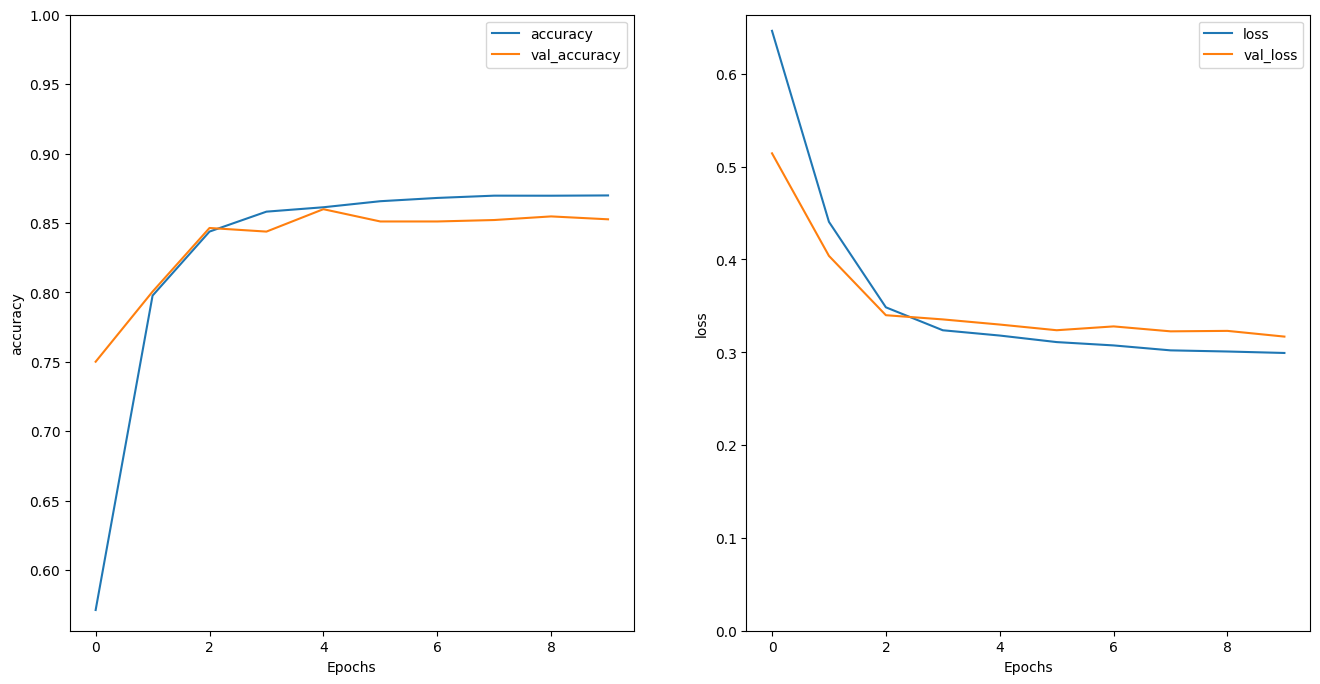

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 0s 26ms/step


## **Stack two or more LSTM layers**

In [ ]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 445s 1s/step - loss: 0.6372 - accuracy: 0.5703 - val_loss: 0.4625 - val_accuracy: 0.7661
Epoch 2/10
391/391 [==============================] - 432s 1s/step - loss: 0.3881 - accuracy: 0.8283 - val_loss: 0.3509 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 422s 1s/step - loss: 0.3380 - accuracy: 0.8538 - val_loss: 0.3378 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 422s 1s/step - loss: 0.3210 - accuracy: 0.8635 - val_loss: 0.3233 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 423s 1s/step - loss: 0.3124 - accuracy: 0.8659 - val_loss: 0.3237 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 424s 1s/step - loss: 0.3047 - accuracy: 0.8690 - val_loss: 0.3274 - val_accuracy: 0.8391
Epoch 7/10
391/391 [==============================] - 425s 1s/step - loss: 0.3039 - accuracy: 0.8710 - val_loss: 0.3220 - val_accuracy: 0.8557

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 115s 295ms/step - loss: 0.3158 - accuracy: 0.8542
Test Loss: 0.31582629680633545
Test Accuracy: 0.854200005531311


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[0.3959979]


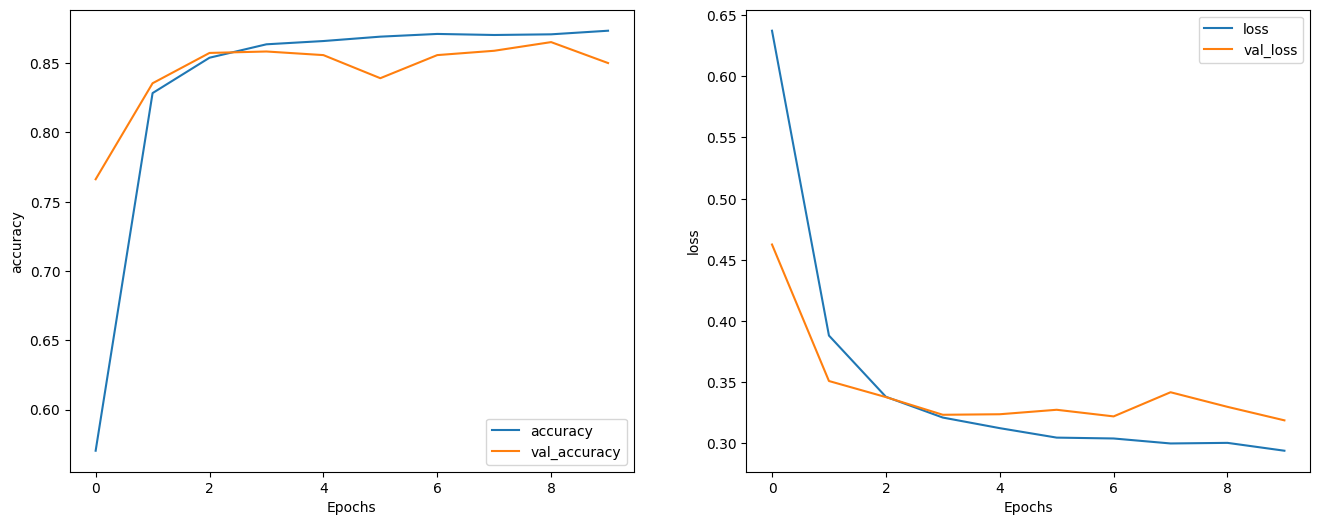

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2


In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
#@title Load Data
path_to_file =tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

1115394/1115394 [==============================] - 0s 0us/step
Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


#### Olah text

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
#@title Prediksi membuat set dan training

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:

for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [ ]:
#@title membuat batch training
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:

model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
#@title uji model
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([14, 17, 58, 48, 64, 16, 11, 14, 48, 13, 14, 52, 46, 46, 34, 65, 53,
       60, 14, 47, 48, 21,  7, 50,  0, 62, 62, 37,  4, 13,  1, 53, 25, 51,
       26, 48, 22, 20,  4, 63,  4, 62, 18, 53, 31, 36, 37,  0, 14, 22, 35,
        2,  7, 38, 59, 63, 40, 25, 65, 48, 57, 33, 45, 49, 25, 45,  2, 23,
        5, 20, 10,  0, 56, 42, 34, 60, 21, 37, 30, 31, 12, 31, 30, 18, 19,
       43,  6, 56, 43, 58, 12, 14, 46,  1, 12, 57, 46, 49,  4, 11])

In [ ]:

print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ust not. I wish\nyou much mirth.\n\nVALERIA:\nWell, then, farewell.\n\nMARCIUS:\nYonder comes news. A wager'

Next Char Predictions:
 b"ADsiyC:Ai?AmggUznuAhiH,k[UNK]wwX$?\nnLlMiIG$x$wEnRWX[UNK]AIV ,YtxaLzirTfjLf J&G3[UNK]qcUuHXQR;RQEFd'qds;Ag\n;rgj$:"


In [ ]:
#@title train model
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189046, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.95983

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
#@title Konfigurasi checkpoint
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 129s 733ms/step - loss: 2.7345
Epoch 2/20
172/172 [==============================] - 127s 735ms/step - loss: 1.9948
Epoch 3/20
172/172 [==============================] - 126s 724ms/step - loss: 1.7093
Epoch 4/20
172/172 [==============================] - 128s 735ms/step - loss: 1.5457
Epoch 5/20
172/172 [==============================] - 130s 747ms/step - loss: 1.4452
Epoch 6/20
172/172 [==============================] - 132s 764ms/step - loss: 1.3765
Epoch 7/20
172/172 [==============================] - 131s 754ms/step - loss: 1.3242
Epoch 8/20
172/172 [==============================] - 130s 751ms/step - loss: 1.2793
Epoch 9/20
172/172 [==============================] - 131s 754ms/step - loss: 1.2370
Epoch 10/20
172/172 [==============================] - 128s 740ms/step - loss: 1.1977
Epoch 11/20
172/172 [==============================] - 131s 757ms/step - loss: 1.1568
Epoch 12/20
172/172 [==============================] - 129s 741

In [ ]:
#@title membuat prediksi satu langkah
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:

start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Father, how like it plees, to arrivide thee
Wait Warwick for the grief this unprupetle than a husband.
Shed him God keep your honour, not forbow,
Were threefold death, and fearless rise for
Angels as launes as a man. O monstrous, not like this:
It chances with dignity! advantaging,
I thank thee, peach denient to you all, A rinner.

Clown:
Laid off than we arrest thine on the worst,
And by that space of glory sales 'ymaked,
He would not be at our pleasure must upon a fight,
And but obeyies but hell always will gent.

PETRUCHIO:
A most innocciaus sir,
The movee no chargets to insign thim in their
evil, on evil with her.

PETRUCHIO:
For being a king of slander no marries, lords;
Stewn in his lamb, and been waters,
And watch an opech. Tut, I chide,
To lay my reason mightst not. O,
You go within mile and ado.

GLOUCESTER:

KING EDWARD IV:
No, my good forbit Bohemia: answered
Deturnedly heaven she's come in pearl;
and make my command of the man that bears him from his mistress
Builty 

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nI know how we will defend at Thursely's chaff:\nCome buy, five wild mother, raily tongue,\nAnd speak I will absend our tongue-corned\nThe favour hath envious music on,\nConform'd a carque-man's appears: all poor enemies\nWill brother of rest o' the tribunes, and together\nHath branches evoil it little lady, graft lost.\nWho was this curtaid you not? 'tis well fool,\nTo twinkled that you'll leave yourself.\nThe way therein his offences it should\npreventerning, their safety hate their thrence--when a good mother,\nThat all the tribunes of the cause of mine\nOut of death in years in honour,\nBut from itsin with Paliand heart? and as a Christian\nfortune still, and so shall see.\n\nFirst Keeper:\nHe'll have you with pild with him.\n\nCAMILLO:\nThat's your daughter: 'tis against whom, forswearing go.\n\nBAPTISTA:\nYou are welcome.\n\nAll:\nComfort.\n\nANTONIO:\nYou most ignoble\nNumber, but we are and ochines;\nFor yet thou shalt be joyfully and weepself:\nThere's smi

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:

states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
The mighty any soft and mildly;
But since he did serve thee, for the law;
And then I see unto Cooki


#Tugas

### **Membuat Custom Loop Training**


In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
#@title Menjalankan Custom Training
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 129s 727ms/step - loss: 2.7195


In [ ]:
#@title Cek Detail Loop dalam train
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1850
Epoch 1 Batch 50 Loss 2.0100
Epoch 1 Batch 100 Loss 1.9793
Epoch 1 Batch 150 Loss 1.8978

Epoch 1 Loss: 1.9910
Time taken for 1 epoch 131.25 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7583
Epoch 2 Batch 50 Loss 1.7426
Epoch 2 Batch 100 Loss 1.7105
Epoch 2 Batch 150 Loss 1.6205

Epoch 2 Loss: 1.7069
Time taken for 1 epoch 129.38 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6091
Epoch 3 Batch 50 Loss 1.5600
Epoch 3 Batch 100 Loss 1.5067
Epoch 3 Batch 150 Loss 1.5496

Epoch 3 Loss: 1.5462
Time taken for 1 epoch 127.84 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4722
Epoch 4 Batch 50 Loss 1.4558
Epoch 4 Batch 100 Loss 1.4707
Epoch 4 Batch 150 Loss 1.4101

Epoch 4 Loss: 1.4483
Time taken for 1 epoch 128.07 sec
_________________________________________________________________

### **PERBEDAAN DENGAN PRAKTIKUM 2**


## Perbedaan 1
Kustomisasi train_step dalam Program Tugas:

Program Tugas menggunakan kelas CustomTraining, yang meng-override metode train_step. Ini memungkinkan kita untuk mendefinisikan langkah-langkah training secara manual dengan GradientTape untuk menangani proses pelatihan dan perhitungan gradien.

Pada Program Praktikum 2, model training dilakukan secara langsung dengan model.fit(...) tanpa kustomisasi train_step, menggunakan langkah default yang disediakan oleh TensorFlow.

Dengan train_step, Program Tugas memiliki kendali lebih besar atas proses training, seperti menghitung loss secara manual dan menentukan kapan serta bagaimana gradien diterapkan. Ini berguna untuk eksperimen khusus atau kebutuhan pelatihan yang lebih kompleks.

## Perbedaan 2
Perhitungan dan Pelaporan Loss dalam Loop Training:

Pada Program Tugas, setelah setiap batch di setiap epoch, loss disimpan dan diperbarui dengan tf.metrics.Mean() untuk memberikan rata-rata loss per epoch. Program juga menampilkan loss setiap 50 batch untuk memantau perkembangan selama training.

Program Praktikum 2 tidak melakukan ini secara eksplisit. Loss hanya ditampilkan sebagai hasil akhir dari model.fit(...), tanpa detail per batch.

## Perbedaan 3
Penyimpanan Model sebagai Checkpoint:

Dalam Program Tugas, model disimpan setiap 5 epoch secara manual menggunakan model.save_weights(...), serta pada akhir training. Ini dilakukan untuk menjaga checkpoint secara berkala, yang membantu menghindari kehilangan progres pelatihan jika terjadi kegagalan.
Di Program Praktikum 2, penyimpanan checkpoint dilakukan dengan callback ModelCheckpoint, yang mengotomatiskan penyimpanan model di setiap epoch sesuai konfigurasi yang diberikan.


## Kesimpulan

Program Tugas dirancang dengan pendekatan yang lebih rendah (low-level) dan memberi kendali lebih besar atas proses pelatihan, cocok untuk eksperimen atau kasus di mana logika pelatihan yang kustom diperlukan. Program Praktkum 2 menggunakan API tinggi TensorFlow, yang lebih ringkas dan cocok untuk pelatihan standar atau cepat.